In [3]:
import os
from tqdm import tqdm
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from transformers import ViTForImageClassification, ViTFeatureExtractor
from collections import Counter, defaultdict
from PIL import Image, ExifTags
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### TSR Model: CNN

In [5]:
# Transformations for the dataset
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)  # GTSRB has 43 classes

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        
cnn_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cnn = torch.load('model/cnn-real-2024-05-26 21:17:57.047997.pth')

In [23]:
resnet_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

resnet = torch.load('model/resnet-real-2024-05-26 21:24:36.606819.pth')

In [8]:
vgg_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

vgg = torch.load('model/vgg-real-2024-05-26 21:31:39.429225.pth')

In [ ]:
VIT = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=43, ignore_mismatched_sizes=True)

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
vit_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

In [70]:
model_type = 'vgg'

if model_type == 'resnet':
    model = resnet
    transform = resnet_transform
elif model_type == 'vgg':
    model = vgg 
    transform = vgg_transform
elif model_type == 'vit':
    print('[!] should not be used!')
    model = VIT
    transform = vit_transform
else:
    model = cnn 
    transform = cnn_transform

model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Prepare Dataset

In [50]:
# Function to correct orientation based on EXIF data
def correct_orientation(image):
    try:
        for orientation in ExifTags.TAGS.keys():
            if ExifTags.TAGS[orientation] == 'Orientation':
                break
        exif = image._getexif()
        if exif is not None:
            orientation = exif.get(orientation)
            if orientation == 3:
                image = image.rotate(180, expand=True)
            elif orientation == 6:
                image = image.rotate(270, expand=True)
            elif orientation == 8:
                image = image.rotate(90, expand=True)
    except (AttributeError, KeyError, IndexError):
        pass
    return image

# Function to load label to image paths
def load_label2image_paths(base_path):
    label2image_paths = defaultdict(list)

    def recurse(current_path, current_label):
        for entry in os.listdir(current_path):
            entry_path = os.path.join(current_path, entry)
            if os.path.isdir(entry_path):
                new_label = current_label + [entry]
                recurse(entry_path, new_label)
            elif entry.lower().endswith('.jpg'):
                label = '_'.join(current_label)
                label2image_paths[label].append(entry_path)

    recurse(base_path, [])
    return label2image_paths

# Custom ImageFolder to include orientation correction
class CustomImageFolder(datasets.ImageFolder):
    def __init__(self, label2image_paths, transform=None):
        self.label2image_paths = label2image_paths
        self.samples = [(path, label) for label, paths in label2image_paths.items() for path in paths]
        self.classes = list(label2image_paths.keys())
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        path, label = self.samples[index]
        with open(path, 'rb') as f:
            img = Image.open(f)
            img = img.convert('RGB')
            img = correct_orientation(img)
        if self.transform is not None:
            img = self.transform(img)
        label_idx = self.class_to_idx[label]
        # FIXME: label idx is 44 in GTSRB
        label_idx = 44 - 1
        return img, label_idx

# Load label to image paths
label2image_paths = load_label2image_paths("data/real-world/processed")

# Transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5,0.5,0.5))
])

# Load the dataset using CustomImageFolder
dataset = CustomImageFolder(label2image_paths, transform=transform)

# Create data loader
data_loader = DataLoader(dataset, batch_size=32 , shuffle=False, num_workers=4) #, pin_memory=True)

# Function to show random images from the dataset
def show_random_images(data_loader, num_images=10):
    # Get a batch of images and labels
    images, labels = next(iter(data_loader))
    
    # Select random indices from the batch
    indices = random.sample(range(len(images)), num_images)
    selected_images = images[indices]
    selected_labels = [dataset.classes[labels[idx]] for idx in indices]

    # Calculate subplot size
    subplot_size = int(num_images ** 0.5)

    # Set up plot layout
    fig, axs = plt.subplots(nrows=subplot_size, ncols=subplot_size, figsize=(20, 12))

    # Show images and labels
    for ax, img, label in zip(axs.ravel(), selected_images, selected_labels):
        img = img.permute(1, 2, 0)  # Convert to HWC format
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Unnormalize
        img = img.clip(0, 1)
        ax.imshow(img)
        ax.set_title(label, fontsize=10)  # Set label, adjust font size
        ax.axis('off')

    # Adjust subplot spacing and layout
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.tight_layout()
    plt.show()

print(len(data_loader))

94


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x72a59229f6d0>
Traceback (most recent call last):
  File "/home/ice1187/car-final/pyenv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/ice1187/car-final/pyenv/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.10/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


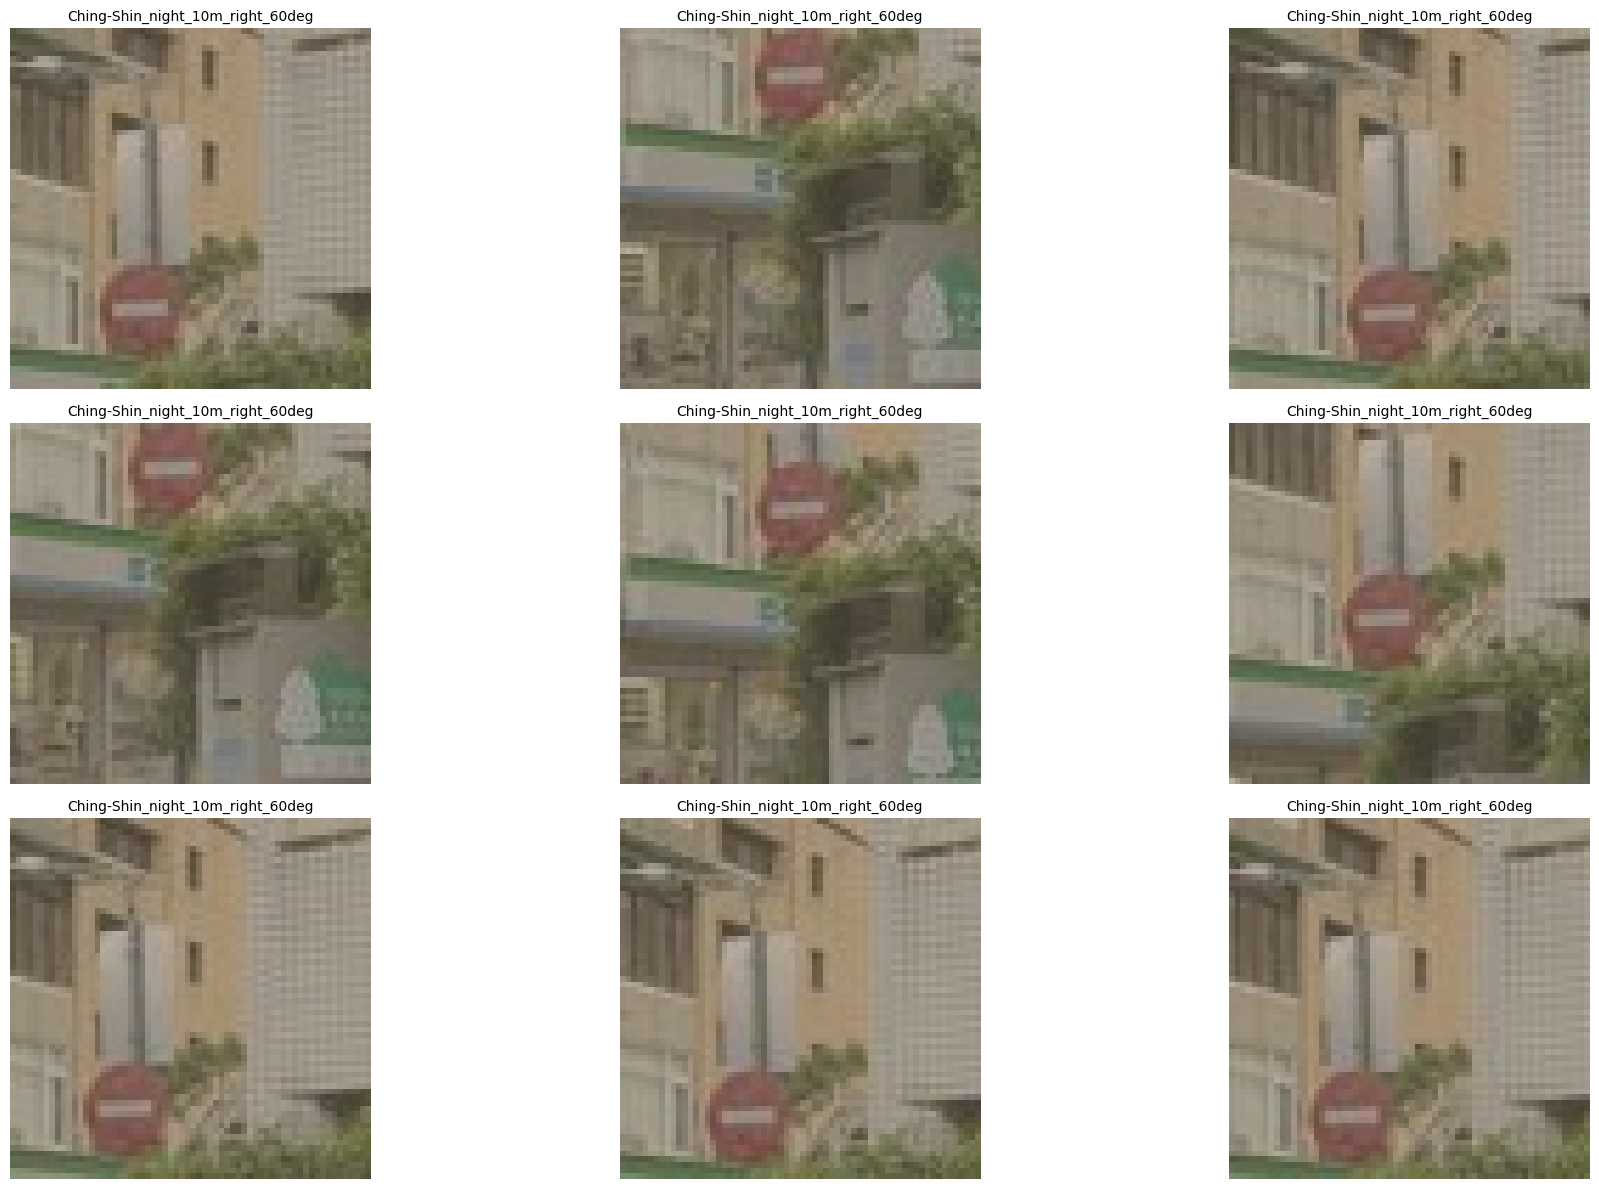

In [47]:
show_random_images(data_loader, num_images=10)

### Evaluation (on Real-World only data)

In [71]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm(data_loader):
        images, labels = images.to(device), labels.to(device)
        if model_type == 'vit':
            outputs = model(images).logits
        else:
            outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        #print(predicted, labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {correct / total:.2%}')

100%|████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:01<00:00, 56.07it/s]

Accuracy: 98.80%


### Attack
- patch size
- patch position
- patch transparency (alpha)

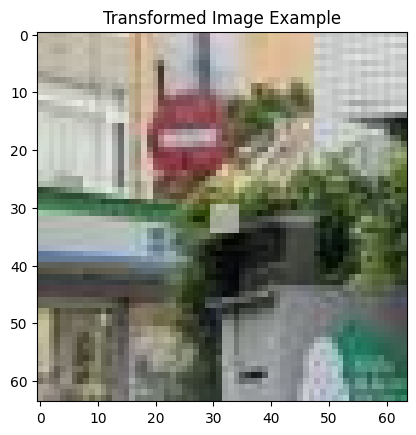

In [72]:
def show_image(image):
    image = image.numpy().transpose((1, 2, 0))
    image = (image * 0.5) + 0.5  # Unnormalize
    plt.imshow(image)
    plt.title('Transformed Image Example')
    plt.show()
    
def add_white_rectangle(image, rect_size=(5, 5), position=(30, 30), alpha=0.5):
    image = image.clone()
    for c in range(image.size(0)):  # Iterate over color channels
        image[c, position[0]:position[0]+rect_size[0], position[1]:position[1]+rect_size[1]] = \
            alpha * 1.0 + (1 - alpha) * image[c, position[0]:position[0]+rect_size[0], position[1]:position[1]+rect_size[1]]
    return image

example_image, _ = dataset[1]
patch_image = add_white_rectangle(example_image)
show_image(patch_image)

In [73]:
# Evaluation after Attack
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm(data_loader):
        images, labels = images.to(device), labels.to(device)
        images = torch.stack([add_white_rectangle(img) for img in images])
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f'Accuracy: {correct / total:.2%}')

100%|████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:02<00:00, 46.04it/s]

Accuracy: 98.33%


In [74]:
# Attack: Different Transparecy
model.eval()

alphas = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
accuracies = []
for alpha in alphas:
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images, labels = images.to(device), labels.to(device)
            images = torch.stack([add_white_rectangle(img, alpha=alpha) for img in images])
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    accuracy = correct / total
    accuracies.append(accuracy)
    print(f'Alpha: {alpha}, Accuracy: {accuracy:.2%}')

100%|████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:02<00:00, 46.07it/s]


Alpha: 0.0, Accuracy: 98.80%


100%|████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:02<00:00, 44.48it/s]


Alpha: 0.2, Accuracy: 98.43%


100%|████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:02<00:00, 46.23it/s]


Alpha: 0.4, Accuracy: 98.33%


100%|████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:02<00:00, 46.11it/s]


Alpha: 0.6, Accuracy: 98.46%


100%|████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:02<00:00, 46.17it/s]


Alpha: 0.8, Accuracy: 98.76%


100%|████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:02<00:00, 44.52it/s]

Alpha: 1.0, Accuracy: 98.59%


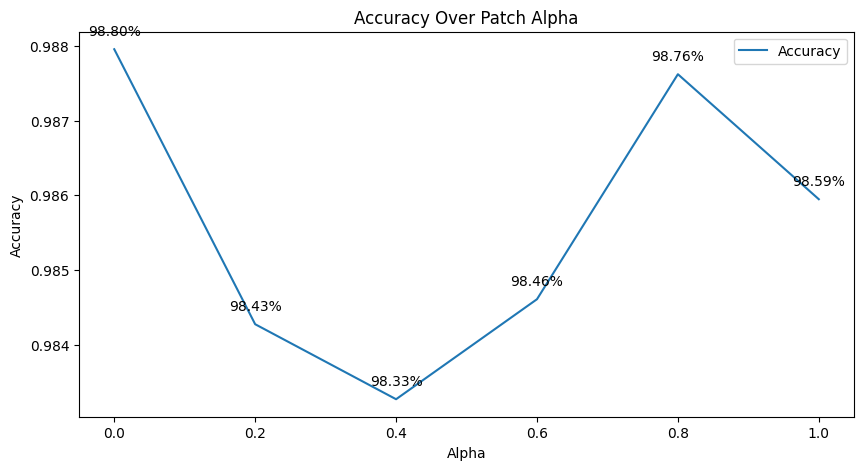

In [75]:
plt.figure(figsize=(10, 5))
plt.plot(alphas, accuracies, label='Accuracy')
for i, txt in enumerate(accuracies):
    plt.annotate(f'{txt:.2%}', (alphas[i], accuracies[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Patch Alpha')
plt.legend()
plt.show()

In [ ]:
# Attack: Different Size
model.eval()

alphas = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
accuracies = []
for alpha in alphas:
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images, labels = images.to(device), labels.to(device)
            images = torch.stack([add_white_rectangle(img, alpha=alpha) for img in images])
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    accuracy = correct / total
    accuracies.append(accuracy)
    print(f'Alpha: {alpha}, Accuracy: {accuracy:.2%}')

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(alphas, accuracies, label='Accuracy')
for i, txt in enumerate(accuracies):
    plt.annotate(f'{txt:.2%}', (alphas[i], accuracies[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Patch Alpha')
plt.legend()
plt.show()